In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import optuna

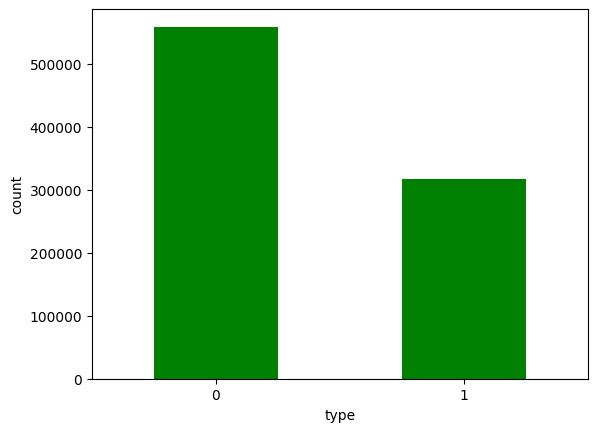

In [2]:
df=pd.read_csv('dataset.csv')
df.dropna(inplace=True)
type_counts=df['type'].value_counts()
type_counts.plot(kind='bar',rot=0,color='green')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

In [3]:
url=list(df['url'])
Type=list(df['type'])

In [4]:
labels=np.array(Type)

In [5]:
def add_spaces_around_punctuation(input_list):
    translation_table = str.maketrans({key: f' {key} ' for key in string.punctuation})
    result_list = [s.translate(translation_table) for s in input_list]
    result_list = [s.split() for s in result_list]

    return result_list

output_list = add_spaces_around_punctuation(url)


output_string = ' '.join([' '.join(words) for words in output_list])


output_string = output_string.replace('[', '').replace(']', '')

In [6]:
alist=output_string.split(" ")

In [7]:
counts = Counter(alist)

In [8]:
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [9]:
reviews_ints = []
for review in output_list:
    reviews_ints.append([vocab_to_int.get(word, 0) for word in review])

In [10]:
lengths = [len(sublist) for sublist in reviews_ints]

max_length = max(lengths)
min_length=min(lengths)
print(max_length)
print(min_length)

364
1


In [11]:
def pad_features(reviews_ints, seq_length):


    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [12]:
seq_length = 364
features = pad_features(reviews_ints, seq_length=seq_length)
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
print(features[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [13]:
split_frac = 0.8
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.1)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

train_x=train_x[:-85]
train_y=train_y[:-85]
val_x=val_x[:-24]
val_y=val_y[:-24]
test_x=test_x[:-23]
test_y=test_y[:-23]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(700900, 364) 
Validation set: 	(17500, 364) 
Test set: 		(157700, 364)


In [14]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size=100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [15]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [16]:
class malicious(nn.Module):
  def __init__(self,vocab_size,output_size,embedding_dim,hidden_dim,n_layers,drop_prob=0.5):
    super(malicious,self).__init__()
    self.output_size=output_size
    self.n_layers=n_layers
    self.hidden_dim=hidden_dim
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc=nn.Linear(hidden_dim,output_size)

  def forward(self,x,hidden):
    batch_size=x.size(0)
    x=x.long()
    embeds=self.embedding(x)
    lstm_out,hidden=self.lstm(embeds,hidden)
    lstm_out=lstm_out[:, -1, :] # getting the last time step output
    output=self.dropout(lstm_out)
    output=F.sigmoid(self.fc(output))
    return output,hidden

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

    return hidden

In [17]:
vocab_size=len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size=1
embedding_dim=400
hidden_dim=256
n_layers=2

model=malicious(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(model)

malicious(
  (embedding): Embedding(650291, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [18]:
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [19]:
def objective(trial):
    # Define the search space for hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 300, 500)
    hidden_dim = trial.suggest_int('hidden_dim', 200, 400)
    n_layers=trial.suggest_int('n_layers',1,3)
    drop_prob = trial.suggest_float('drop_prob', 0.1, 0.5)

    # Build the model with suggested hyperparameters
    model = malicious(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    if(train_on_gpu):
        model.cuda()

    # Training loop
    epochs=4
    counter=0
    clip=5
    for e in range(epochs):
        model.train()
        h = model.init_hidden(batch_size)
        for Features, Labels in train_loader:
            counter += 1
            if(train_on_gpu):
                Features, Labels = Features.cuda(), Labels.cuda()
            h = tuple([each.data for each in h])
            model.zero_grad()
            output, h = model(Features, h)
            loss = criterion(output.squeeze(), Labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

    # Validation loop
    val_losses = []
    model.eval()
    for Features, Labels in valid_loader:
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])
        if(train_on_gpu):
            Features, Labels = Features.cuda(), Labels.cuda()
        output, val_h = model(Features, val_h)
        val_loss = criterion(output.squeeze(), Labels.float())
        val_losses.append(val_loss.item())

    return np.mean(val_losses)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)  

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-02-12 20:46:45,395] A new study created in memory with name: no-name-69efc41e-a6df-437c-9a35-697ea43c105a
[I 2024-02-12 22:05:17,342] Trial 0 finished with value: 0.07219779255234503 and parameters: {'embedding_dim': 453, 'hidden_dim': 212, 'n_layers': 3, 'drop_prob': 0.22667268160734158}. Best is trial 0 with value: 0.07219779255234503.
c:\Users\Ryzen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22714807894987155 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-02-12 22:49:23,515] Trial 1 finished with value: 0.06146158152027056 and parameters: {'embedding_dim': 325, 'hidden_dim': 238, 'n_layers': 1, 'drop_prob': 0.22714807894987155}. Best is trial 1 with value: 0.06146158152027056.


Number of finished trials:  2
Best trial:
  Value:  0.06146158152027056
  Params: 
    embedding_dim: 325
    hidden_dim: 238
    n_layers: 1
    drop_prob: 0.22714807894987155
